# Import Libs
### The necessary libraries for data manipulation, preprocessing, model training, and hyperparameter tuning are imported here.

In [53]:
import pandas as pd
import numpy as np
from collections import defaultdict

import re
import unicodedata
import string
import wordninja
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import spacy
from textblob import TextBlob

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_auc_score

In [2]:
# Set up document object in spaCy and define stop words and lemmatizer
nlp = spacy.load('en_core_web_sm')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# EDA
### Initial exploration of the dataset includes checking the distribution of target labels (disaster vs non-disaster tweets).


In [55]:
# Import DataFrame
train_df = pd.read_csv('train.csv')

In [4]:
# Check first 5 rows
train_df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Check missing values and target distribution
train_df.groupby(['target']).count()

,id,keyword,location,text
target,,,,
0,4342,4323,2884,4342
1,3271,3229,2196,3271


In [7]:
# Get counts for plotting
group_counts = train_df['target'].value_counts()
group_counts

0    4342
1    3271
Name: target, dtype: int64

In [8]:
fig = px.bar(group_counts, x=group_counts.index, y=group_counts,
       labels={'x': 'Target Group', 'y': 'Number of Events in Class'},
       title='Distribution of Target Groups')

fig.update_layout(
    width=800,
    height=400
)

fig.update_traces(marker_color=['green', 'red'])

In [9]:
# Get percentage values
round((group_counts/train_df.shape[0])*100, 2)

0    57.03
1    42.97
Name: target, dtype: float64

# Feature Engineering

## Generating Metafeatures
### Metafeatures like character count, word count, and average word length are generated to aid model training.

In [10]:
def generate_metafeatures(train_df):
    """
    Generate meta-features for text data in a DataFrame.

    Parameters:
    -----------
    train_df : pandas.DataFrame
        The input DataFrame containing a 'text' column with the text data to be processed.

    Returns:
    --------
    pandas.DataFrame
        A new DataFrame that includes the original data along with the following new meta-features:
        - char_count: Total number of characters in the text.
        - word_count: Total number of words in the text.
        - avg_word_length: Average length of words in the text.
        - unique_word_count: Number of unique words in the text.
        - uppercase_count: Number of uppercase characters in the text.
        - lowercase_count: Number of lowercase characters in the text.
        - punctuation_count: Total count of punctuation marks ('!', '?', ',', '.') in the text.
    """
    def process_text(text):
        # Basic counts
        char_count = len(text)
        word_count = len(text.split())

        # Word-based features
        words = text.split()
        avg_word_length = np.mean([len(word) for word in words]) if words else 0
        unique_words = len(set(words))
        
        # Character-based features
        uppercase_count = sum(1 for c in text if c.isupper())
        lowercase_count = sum(1 for c in text if c.islower())

        # Punctuation-based features
        punctuation_count = sum(text.count(p) for p in '!?,.')

        return {
            'char_count': char_count,
            'word_count': word_count,
            'avg_word_length': avg_word_length,
            'unique_word_count': unique_words,
            'uppercase_count': uppercase_count,
            'lowercase_count': lowercase_count,
            'punctuation_count': punctuation_count
        }

    # Apply the process_text function to each text in the DataFrame
    metafeatures = []
    for text in tqdm(train_df['text'], desc="Generating metafeatures"):
        metafeatures.append(process_text(text))

    # Create a new DataFrame with the metafeatures
    metafeatures_df = pd.DataFrame(metafeatures)

    # Concatenate the original DataFrame with the new metafeatures
    return pd.concat([train_df, metafeatures_df], axis=1)



In [11]:
# Adding metafeatures to train dataset
train_df = generate_metafeatures(train_df)

Generating metafeatures: 100%|██████████| 7613/7613 [00:00<00:00, 44904.07it/s]


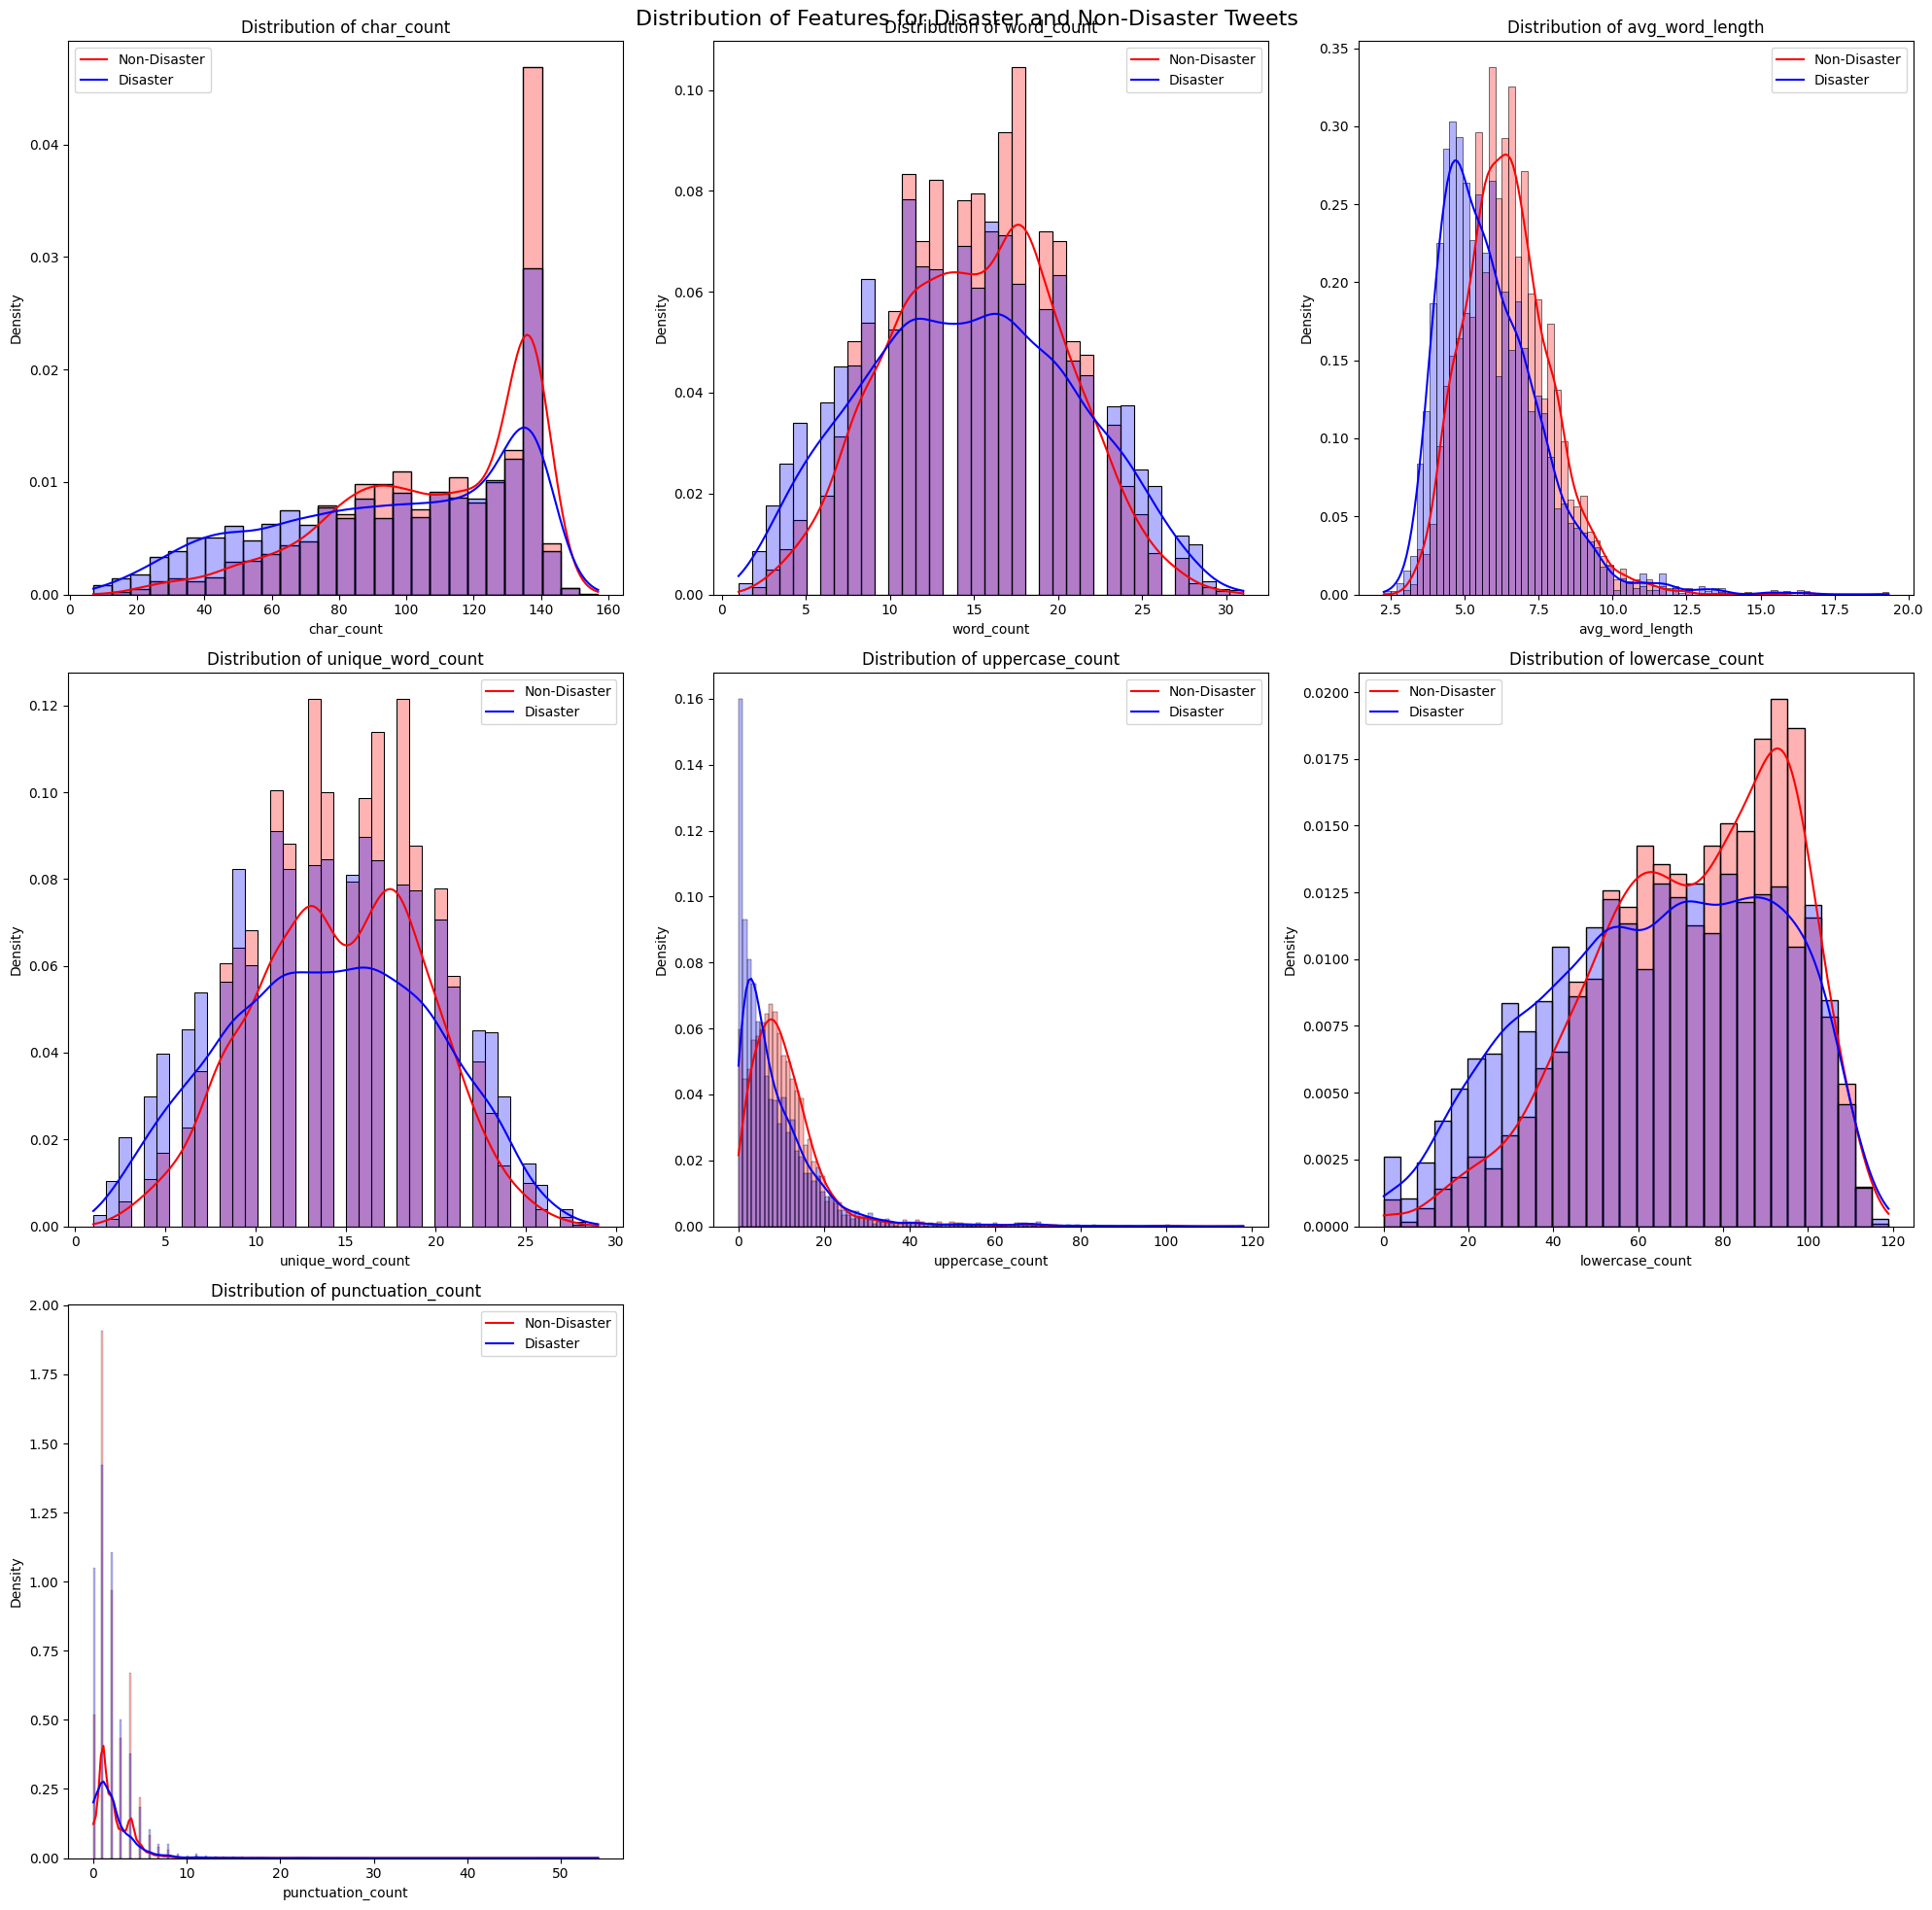

In [12]:
# List of new features
new_features = ['char_count', 'word_count', 'avg_word_length', 'unique_word_count',
                'uppercase_count', 'lowercase_count', 'punctuation_count']
color_map = {0: 'blue', 1: 'red'}

# Set up the matplotlib figure
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
fig.suptitle('Distribution of Features for Disaster and Non-Disaster Tweets', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create a histogram for each feature
for i, feature in enumerate(new_features):
    sns.histplot(data=train_df, x=feature, hue='target', 
                 kde=True, stat="density", common_norm=False,
                 palette=color_map, alpha=0.3, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].legend(['Non-Disaster', 'Disaster'])

# Remove any unused subplots
for i in range(len(new_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

From distributions we can see, that generated metafeatures have some value for model training, as they distinguish two classes

## Text Cleaning
### We clean the text by removing URLs, stop words, and unnecessary characters, and perform lemmatization.

In [13]:
def clean_text(doc):
    # Remove URLs
    doc = re.sub(r'http\S+', '', doc)
    doc = re.sub(r'www\.\S+', '', doc)
    # Remove unusual characters and normalize
    doc = unicodedata.normalize('NFKD', doc).encode('ascii', 'ignore').decode('ascii')
    # Named entity removal (from your original function)
    document = nlp(doc)
    ents = [e.text for e in document.ents]
    text_without_entities = [token.text for token in document if token.text not in ents]
    doc = ' '.join(text_without_entities)
    # Lowercase and strip
    doc = doc.lower().strip()
    # Remove HTML tags and hyphens
    doc = doc.replace('</br>', ' ').replace('-', ' ')
    # Remove punctuation and digits (from your original function)
    doc = ''.join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    # Tokenize and remove stopwords
    tokens = [token for token in doc.split() if token not in stop_words]
    # Word segmentation for compound words
    tokens = [word for token in tokens for word in wordninja.split(token)]
    # Lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

In [ ]:
# Adding metafeatures to train dataset
train_df = generate_metafeatures(train_df)

Generating metafeatures: 100%|██████████| 7613/7613 [00:00<00:00, 44904.07it/s]


In [ ]:
def clean_text(doc):
    """
    Clean and preprocess a text document. 
    
    This function performs a series of text cleaning and preprocessing steps on the input document,
    including URL removal, character normalization, named entity removal, lowercasing,
    punctuation and digit removal, stopword removal, word segmentation, and lemmatization.

    Parameters:
    -----------
    doc : str
        The input text document to be cleaned and preprocessed.

    Returns:
    --------
    str
        The cleaned and preprocessed text as a single string with tokens joined by spaces.
    """
    # Remove URLs
    doc = re.sub(r'http\S+', '', doc)
    doc = re.sub(r'www\.\S+', '', doc)
    # Remove unusual characters and normalize
    doc = unicodedata.normalize('NFKD', doc).encode('ascii', 'ignore').decode('ascii')
    # Named entity removal
    document = nlp(doc)
    ents = [e.text for e in document.ents]
    text_without_entities = [token.text for token in document if token.text not in ents]
    doc = ' '.join(text_without_entities)
    # Lowercase and strip
    doc = doc.lower().strip()
    # Remove HTML tags and hyphens
    doc = doc.replace('</br>', ' ').replace('-', ' ')
    # Remove punctuation and digits
    doc = ''.join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    # Tokenize and remove stopwords
    tokens = [token for token in doc.split() if token not in stop_words]
    # Word segmentation for compound words
    tokens = [word for token in tokens for word in wordninja.split(token)]
    # Lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

In [14]:
train_df['cleaned_text'] = train_df['text'].apply(clean_text)

# Embedding Preparation
### The pretrained GloVe embeddings are loaded and used to convert the text data into numerical vectors.


In [15]:

# glove_input_file = 'C:\Desktop\embeddings\glove.6B.300d.txt'
word2vec_output_file = 'C:\Desktop\embeddings\glove.6B.300d.word2vec.txt'
# glove2word2vec(glove_input_file, word2vec_output_file)

In [16]:
word_vectors = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
word_vector_vocab = set(word_vectors.key_to_index.keys())
print(f"Loaded {len(word_vectors.key_to_index)} word vectors.")

Loaded 400000 word vectors.


In [17]:
def analyze_oov_words(texts, word_vectors):
    all_words = set()
    oov_words = set()
    word_counts = Counter()

    for text in texts:
        words = text.split()
        all_words.update(words)
        word_counts.update(words)
        oov_words.update([word for word in words if word not in word_vectors])

    total_words = len(all_words)
    total_oov = len(oov_words)
    oov_percentage = (total_oov / total_words) * 100

    print(f"Total unique words: {total_words}")
    print(f"Total OOV words: {total_oov}")
    print(f"Percentage of OOV words: {oov_percentage:.2f}%")

    print("\nTop 10 most common OOV words:")
    for word, count in sorted(((word, count) for word, count in word_counts.items() if word in oov_words), 
                              key=lambda x: x[1], reverse=True)[:10]:
        print(f"{word}: {count}")

    return oov_words

In [18]:
oov_words = analyze_oov_words(train_df['cleaned_text'], word_vectors)

Total unique words: 11663
Total OOV words: 83
Percentage of OOV words: 0.71%

Top 10 most common OOV words:
freakiest: 7
aaaaaa: 4
nsfw: 4
yyyy: 3
rker: 2
joki: 2
prosy: 2
dddd: 2
cken: 2
lter: 2


### The pretrained GloVe embeddings are loaded and used to convert the text data into numerical vectors.


In [37]:
def get_text_embedding(text, word_vectors, embedding_dim=300):
    words = text.split()
    embedding = np.zeros((embedding_dim,))
    valid_words = [word for word in words if word in word_vectors]
    
    if valid_words:
        embedding = np.mean([word_vectors[word] for word in valid_words], axis=0)
    return embedding

def generate_embeddings(df, word_vectors, embedding_dim=300):
    return np.vstack(df['cleaned_text'].apply(lambda text: get_text_embedding(text, word_vectors, embedding_dim)).values)


In [38]:
embeddings = generate_embeddings(train_df, word_vectors)
# Step 2: Extract the metafeatures
metafeatures = train_df[['char_count', 'word_count', 'avg_word_length', 
                         'unique_word_count', 'uppercase_count', 
                         'lowercase_count', 'punctuation_count']].values

# Step 3: Combine embeddings and metafeatures
combined_features = np.hstack((embeddings, metafeatures))

# Model Training

## Finding Base Model
### We train and evaluate various machine learning models, including Logistic Regression, Random Forest, and XGBoost.


In [39]:
X_train, X_test, y_train, y_test = train_test_split(combined_features, train_df['target'], test_size=0.2, random_state=42)


In [40]:
def train_evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Evaluate the model
    print(f"{type(model).__name__} Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
    print(classification_report(y_test, y_pred))
    print("\n")

In [43]:
logreg = LogisticRegression(max_iter=10000)
train_evaluate_model(logreg, X_train, X_test, y_train, y_test)

LogisticRegression Results:
Accuracy: 0.7899
ROC AUC: 0.8456
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       874
           1       0.77      0.72      0.75       649

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523





In [51]:
# Step 6: Define the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}


In [52]:
# Step 7: Train and evaluate each model
for model_name, model in models.items():
    print(f"Training and evaluating {model_name}...")
    train_evaluate_model(model, X_train, X_test, y_train, y_test)
    

Training and evaluating Logistic Regression...


c:\Users\alexe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression Results:
Accuracy: 0.7938
ROC AUC: 0.8462
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       874
           1       0.78      0.72      0.75       649

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.79      1523
weighted avg       0.79      0.79      0.79      1523



Training and evaluating Random Forest...
RandomForestClassifier Results:
Accuracy: 0.7958
ROC AUC: 0.8341
              precision    recall  f1-score   support

           0       0.79      0.89      0.83       874
           1       0.82      0.67      0.74       649

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523



Training and evaluating XGBoost...


c:\Users\alexe\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning:

[17:24:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




XGBClassifier Results:
Accuracy: 0.8024
ROC AUC: 0.8505
              precision    recall  f1-score   support

           0       0.80      0.87      0.84       874
           1       0.81      0.71      0.75       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



Training and evaluating Neural Network...
MLPClassifier Results:
Accuracy: 0.7676
ROC AUC: 0.8161
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       874
           1       0.74      0.70      0.72       649

    accuracy                           0.77      1523
   macro avg       0.76      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523





# RandomizedSearchCV for XGBoost
### RandomizedSearchCV is used to tune the hyperparameters of the XGBoost model for optimal performance.


In [54]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1],
    'gamma': [0, 0.1, 0.2, 0.5]
}

# Create the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=xgb_model, 
    param_distributions=param_grid, 
    n_iter=50,  # Number of parameter settings to try
    scoring='roc_auc',  # Optimizing based on ROC AUC score
    cv=5,  # 5-fold cross-validation
    verbose=1, 
    n_jobs=-1,  # Use all CPU cores
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", random_search.best_params_)
print("Best ROC AUC score: ", random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\alexe\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning:

[17:37:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Best parameters found:  {'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.6}
Best ROC AUC score:  0.8622076310902642


# Submission 